In [1]:
import numba
import sys
sys.path.insert(0, '../python_lib')
import networkx as nx
import numpy as np
import graph_gen
import model
import random
from collections import defaultdict
import torch
import math
import solvers
import imp

In [2]:
%matplotlib inline

# Spin system on tree network

### inter_H -> random external fields

### j_start -> values of ferromagnet interactions

We generate a tree:
1. ordered from a root
2. non-ordered (the same nodes are swapped)

In [136]:
Degree = 3 # degree
Height = 3 # Height of the tree

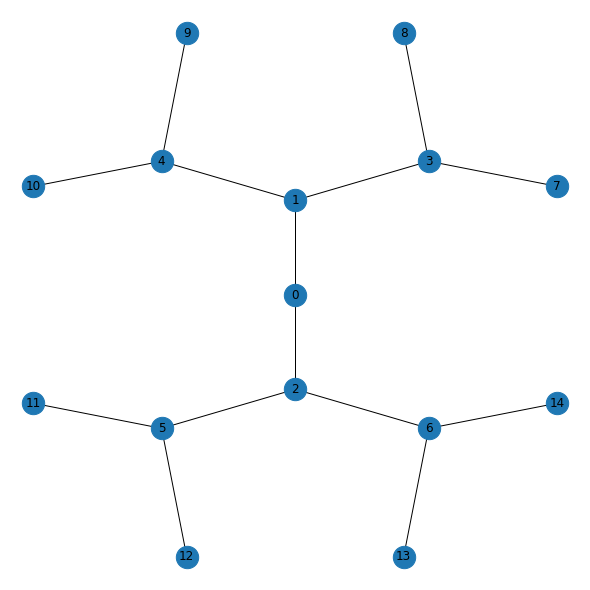

[[5, 4]]


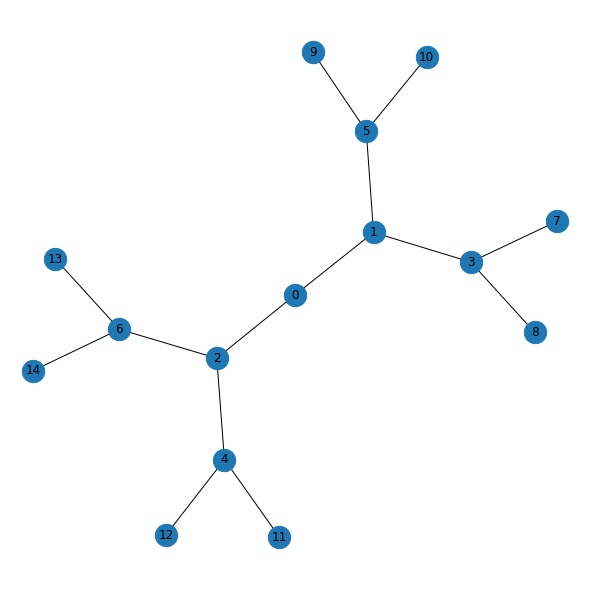

In [137]:
import imp 

import graph_gen
imp.reload(graph_gen)
N, J_interaction = graph_gen.tree_interaction(Degree,Height)

inter_H = 4
H = inter_H * (2.* np.random.random(N) - 1)
#H = np.zeros(N)

num_swap = 1
J_interaction_rand, H_rand = graph_gen.order_rand(N, 
                                                  J_interaction, 
                                                  H, num_swap=num_swap)

graph_gen.plot_matrix_graph(J_interaction_rand)

betas = np.arange(1e-6,2,1e-2)
betas_fast = np.arange(0.1,2,4e-1)

j_start = 1
j = graph_gen.fixed_value(j_start)
J = graph_gen.set_J(J_interaction, j)
J_rand = graph_gen.set_J(J_interaction_rand, j)

#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

# Exact solutions
enumerating all configurations.

In [138]:
import model
imp.reload(model)
tree = model.model(N, H, J, J_interaction)
tree_rand = model.model(N, H_rand, J_rand, J_interaction_rand)

In [139]:
beta = 0.2
tree.exact(beta)
tree_rand.exact(beta);

beta: 0.2, Fe: -4.150 Energy: -1.35 M: 0.431 S: 0.5591.26
beta: 0.2, Fe: -4.150 Energy: -1.35 M: 0.431 S: 0.559.288


# Neural network solutions
## ordered case

In [140]:
import bp_nn
imp.reload(bp_nn)
bias = True
net = bp_nn.bp_nn(tree.N, tree, bias, z2=False)
net.train(beta=beta, 
          lr=0.01, 
        batch_size=1000,
         std_fe_limit=0.00001, 
)
net.compute_stat_is(beta, batch_size=10000)

 0.20 2262 fe: -4.150 +- 0.00001 E: -1.394, S: 0.551, M: 0.44, B1 = 0.0299
free_energy: -4.150,  std_fe: 0.00000, mag_mean: 0.432, entropy: 0.559 energy: -1.357

tensor(-4.1500, dtype=torch.float64)

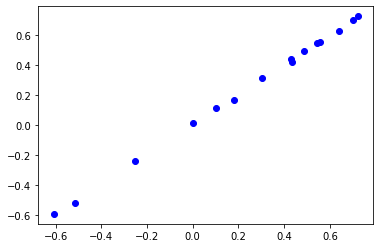

In [141]:
import matplotlib.pyplot as plt
plt.plot(net.M_i,tree.M_i_mean , 'bo')

In [142]:
tree_c = tree.Corr_neigh.flatten()
nn_c = net.Corr_neigh.numpy().flatten()
tree_c = tree_c[tree_c != 0]
nn_c = nn_c[nn_c != 0]

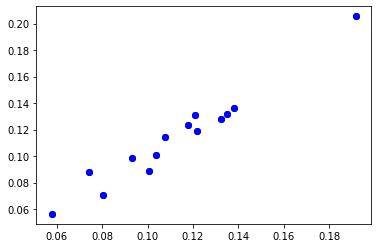

In [143]:
import matplotlib.pyplot as plt

plt.plot(tree_c, nn_c , 'bo');

In [144]:
tree_c = tree.Corr.flatten()
nn_c = net.Corr.numpy().flatten()
tree_c = tree_c[tree_c != 0]
nn_c = nn_c[nn_c != 0]

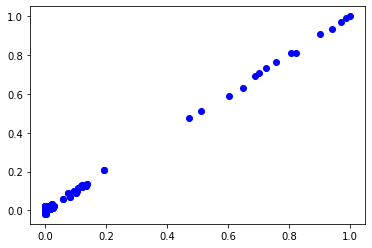

In [145]:
import matplotlib.pyplot as plt

plt.plot(tree_c, nn_c , 'bo');

# NN more

In [147]:
import bp_nn_more
imp.reload(bp_nn_more)
bias = True
net = bp_nn_more.bp_nn_more(tree, bias)
net.train(beta=beta, 
          lr=0.01, 
        batch_size=1000,
         std_fe_limit=0.00001, 
)
net.compute_stat_is(beta, batch_size=10000)

 0.20 2304 fe: -4.150 +- 0.00001 E: -1.362, S: 0.558, M: 0.434, B1 = 0.029
free_energy: -4.150,  std_fe: 0.00000, mag_mean: 0.435, entropy: 0.557 energy: -1.365

tensor(-4.1500, dtype=torch.float64)

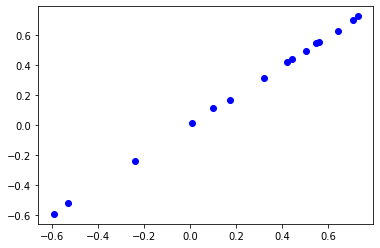

In [148]:
import matplotlib.pyplot as plt
plt.plot(net.M_i,tree.M_i_mean , 'bo')

In [149]:
tree_c = tree.Corr.flatten()
nn_c = net.Corr.numpy().flatten()
tree_c = tree_c[tree_c != 0]
nn_c = nn_c[nn_c != 0]

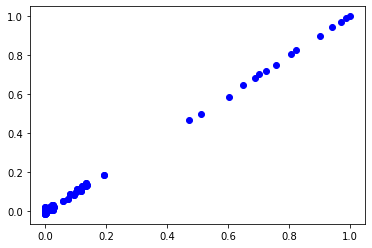

In [150]:
import matplotlib.pyplot as plt

plt.plot(tree_c, nn_c , 'bo');

## random case

In [88]:
import bp_nn
imp.reload(bp_nn)

net_rand = bp_nn.bp_nn(tree_rand.N, tree_rand, True, z2=False, init_zero=False,)
                      
net_rand.train(beta=beta, lr=0.01, 
           max_step=1000,
               opt="adam")


 0.20 1000 fe: -4.208 +- 0.02661 E: -1.396, S: 0.562, M: 0.438, B1 = -1.213

{'free_energy_mean': tensor(-4.2076, dtype=torch.float64),
 'free_energy_std': tensor(0.0266, dtype=torch.float64),
 'entropy_mean': tensor(0.5623, dtype=torch.float64, grad_fn=<DivBackward0>),
 'energy_mean': tensor(-1.3961, dtype=torch.float64),
 'mag': tensor([-0.5300,  0.4520, -0.4380,  0.0060, -0.7060,  0.2840, -0.5960,  0.3980,
         -0.6320, -0.3240, -0.3020,  0.3080,  0.6540,  0.2920, -0.6460]),
 'mag_mean': tensor(0.4379)}

In [89]:
net_rand.compute_stat_is(beta, batch_size=10000)


free_energy: -4.208,  std_fe: 0.00003, mag_mean: 0.440, entropy: 0.561 energy: -1.405

tensor(-4.2081, dtype=torch.float64)

# Large networks BP solution

In [5]:
Degree = 3 # degree
Height = 6 # Height of the tree

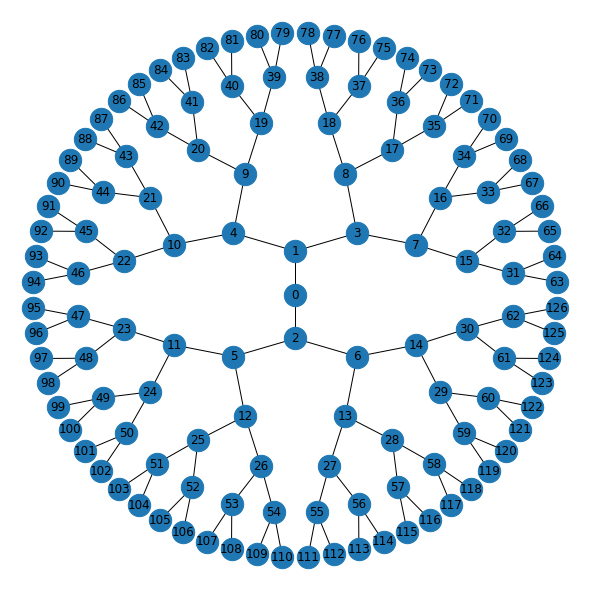

[[90, 58], [12, 109], [11, 115]]


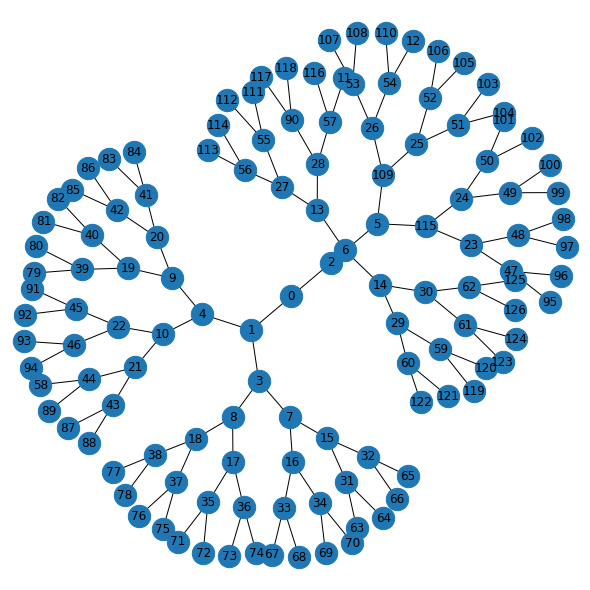

In [6]:
import imp 

import graph_gen
imp.reload(graph_gen)
N, J_interaction = graph_gen.tree_interaction(Degree,Height)

inter_H = 4
H = inter_H * (2.* np.random.random(N) - 1)
#H = np.zeros(N)

num_swap = 3
J_interaction_rand, H_rand = graph_gen.order_rand(N, 
                                                  J_interaction, 
                                                  H, num_swap=num_swap)

graph_gen.plot_matrix_graph(J_interaction_rand)

betas = np.arange(1e-6,2,1e-2)
betas_fast = np.arange(0.1,2,4e-1)

j_start = 1
j = graph_gen.fixed_value(j_start)
J = graph_gen.set_J(J_interaction, j)
J_rand = graph_gen.set_J(J_interaction_rand, j)

#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

In [13]:
J_interaction

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
J

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
import model
imp.reload(model)
tree = model.model(N, H, J, J_interaction)
tree_rand = model.model(N, H_rand, J_rand, J_interaction_rand)

In [10]:
import bp_solver
bp_sol = bp_solver.BP_solver(tree)
beta = 0.2

In [15]:
bp_sol.M

array([[0.        , 0.52905899, 0.47482015, ..., 0.        , 0.        ,
        0.        ],
       [0.40017347, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.35882296, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [11]:
bp_sol.converge(beta)

fe: -4.031, ener: -1.061, M: 0.344, iter 8


In [12]:
bp_sol.free_energy(beta)

-4.031334890572943

In [97]:
import bp_nn
imp.reload(bp_nn)
bias = True
net = bp_nn.bp_nn(tree.N, tree, bias, z2=False)
net.train(beta=beta, 
          lr=0.01, 
        batch_size=1000,
         std_fe_limit=0.00001, 
)
net.compute_stat_is(beta, batch_size=10000)

 0.20 2036 fe: -4.088 +- 0.00001 E: -1.169, S: 0.584, M: 0.38, B1 = 0.2900
free_energy: -4.088,  std_fe: 0.00000, mag_mean: 0.381, entropy: 0.583 energy: -1.173

tensor(-4.0875, dtype=torch.float64)

In [98]:
net.compute_stat_is(beta, batch_size=10000)


free_energy: -4.088,  std_fe: 0.00000, mag_mean: 0.379, entropy: 0.583 energy: -1.171

tensor(-4.0875, dtype=torch.float64)

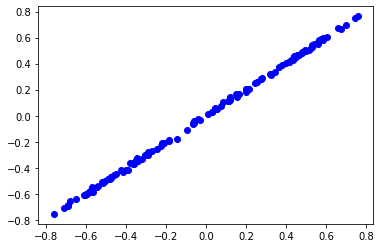

In [101]:
import matplotlib.pyplot as plt
plt.plot(net.M_i,bp_sol.M_i , 'bo')

In [104]:
tree_c = bp_sol.Corr_neigh.flatten()
nn_c = net.Corr_neigh.numpy().flatten()
tree_c = tree_c[tree_c != 0]
nn_c = nn_c[nn_c != 0]

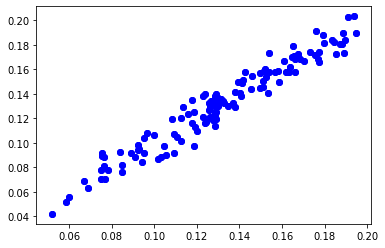

In [105]:
import matplotlib.pyplot as plt

plt.plot(tree_c, nn_c , 'bo');

In [ ]:
bp_sol.